In [81]:
import os
import onnx
import torch

model_dir = os.environ['FINN_ROOT'] + "/notebooks/end2end_example/cnn-dizeratie"
print("Model dir:", model_dir)
torch.set_num_threads(2)

Model dir: /home/stefan/finn/notebooks/end2end_example/cnn-dizeratie


In [82]:
!pip install kaggle

Defaulting to user installation because normal site-packages is not writeable


In [83]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [84]:
!mkdir -p data_uta_rldd
!kaggle datasets download -d minhngt02/uta-rldd -p data_uta_rldd --force
!ls data_uta_rldd

Dataset URL: https://www.kaggle.com/datasets/minhngt02/uta-rldd
License(s): CC0-1.0
100%|█████████████████████████████████████▊| 2.76G/2.77G [00:03<00:00, 1.07GB/s]
100%|███████████████████████████████████████| 2.77G/2.77G [00:04<00:00, 666MB/s]
UTA_RLDD_raw  uta-rldd.zip


In [85]:
!unzip -oq data_uta_rldd/uta-rldd.zip -d data_uta_rldd/UTA_RLDD_raw
print("Unzip completed.")

Unzip completed.


In [86]:
import os
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

# -------------------------------------------------------
# 1. Root folder where you unzipped the UTA-RLDD Kaggle dataset
#    Adjust this path to match your environment.
# -------------------------------------------------------
uta_root = "data_uta_rldd/UTA_RLDD_raw"   # <-- change if needed

train_root = os.path.join(uta_root, "train")
val_root   = os.path.join(uta_root, "val")
test_root  = os.path.join(uta_root, "test")

# -------------------------------------------------------
# 2. Transforms: resize to 128x128, tensor + normalization
# -------------------------------------------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
])

# 2) No augmentation, only resize + normalize: VAL/TEST
eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5]),
])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5],
#                          std=[0.5, 0.5, 0.5]),
# ])

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

full_dataset = ImageFolder(root= os.path.join(uta_root, "train") , transform=transform)
# -------------------------------------------------------
# 3. Build train / val / test datasets from folders
# -------------------------------------------------------
train_quantized_dataset = ImageFolder(root=train_root, transform=transform)
val_quantized_dataset   = ImageFolder(root=val_root,   transform=eval_transform)
test_quantized_dataset  = ImageFolder(root=test_root,  transform=eval_transform)

print("Classes:", train_quantized_dataset.classes)
print("Train images:", len(train_quantized_dataset))
print("Val   images:", len(val_quantized_dataset))
print("Test  images:", len(test_quantized_dataset))

# Inspect one sample from train
x0, y0 = train_quantized_dataset[0]
print("Sample shape:", x0.shape)        # (3, 128, 128)
print("Sample label index:", y0)        # 0 or 1
print("Label name:", train_quantized_dataset.classes[y0])
print("Class names:", full_dataset.classes)

Classes: ['active', 'fatigue']
Train images: 9054
Val   images: 1824
Test  images: 909
Sample shape: torch.Size([3, 128, 128])
Sample label index: 0
Label name: active
Class names: ['active', 'fatigue']


Random TRAIN sample:


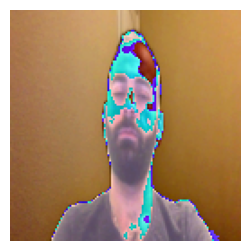

Title: Train sample
Label index: 0
--------------------------------------------------
Random TEST sample:


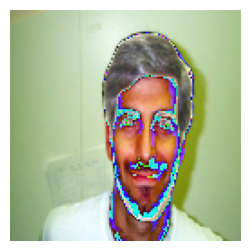

Title: Test sample
Label index: 0
--------------------------------------------------


In [87]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def show_random_sample_from_subset(subset, title):
    # subset is a torch.utils.data.Subset
    # subset.dataset is the underlying ImageFolder
    # subset.indices is the list of indices into the ImageFolder

    # pick a random index inside the subset
    subset_idx = random.randint(0, len(subset) - 1)
    # real_idx = subset.indices[subset_idx]   # index inside ImageFolder

    # get image + label
    img, label = subset[subset_idx]

    # get file path
    # filepath, _ = subset.dataset.samples[real_idx]

    # convert tensor to PIL for display
    img_pil = F.to_pil_image(img)

    plt.figure(figsize=(3, 3))
    plt.imshow(img_pil)
    # plt.title(f"{title}\nLabel: {subset.dataset.classes[label]}")
    plt.axis("off")
    plt.show()

    # also print details in text
    print(f"Title: {title}")
    print(f"Label index: {label}")
    # print(f"Label name: {subset.dataset.classes[label]}")
    # print(f"File path: {filepath}")
    print("--------------------------------------------------")


print("Random TRAIN sample:")
show_random_sample_from_subset(train_quantized_dataset, "Train sample")

print("Random TEST sample:")
show_random_sample_from_subset(test_quantized_dataset, "Test sample")


In [88]:
from torch.utils.data import DataLoader

batch_size = 16   # safer for larger images; adjust later if needed

train_quantized_loader = DataLoader(
    train_quantized_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,      # try 4; reduce to 0 if errors
    pin_memory=False
)

test_quantized_loader = DataLoader(
    test_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

val_quantized_loader = DataLoader(
    val_quantized_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=False
)

In [89]:
count = 0
for x, y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        break

Input shape for 1 batch: torch.Size([16, 3, 128, 128])
Label shape for 1 batch: torch.Size([16])


In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Target device: " + str(device))

Target device: cpu


In [91]:
num_classes = len(full_dataset.classes) 
print("Number of classes:", num_classes, "->", full_dataset.classes)

Number of classes: 2 -> ['active', 'fatigue']


In [92]:
#### MODEL 6 #### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN(nn.Module):
    """
    Lighter version of the Keras-style model:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.5) -> Dense(32) -> Dense(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # --------- Block 1: 3 -> 16 ---------
        self.conv1 = QuantConv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool1 = nn.MaxPool2d(2, 2)   # H,W: 128 -> 64

        # --------- Block 2: 16 -> 32 ---------
        self.conv2 = QuantConv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act2 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool2 = nn.MaxPool2d(2, 2)   # 64 -> 32

        # --------- Block 3: 32 -> 32 ---------
        self.conv3 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act3 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool3 = nn.MaxPool2d(2, 2)   # 32 -> 16

        # --------- Block 4: 32 -> 32 ---------
        self.conv4 = QuantConv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act4 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )
        self.pool4 = nn.MaxPool2d(2, 2)   # 16 -> 8

        # --------- Compute feature_dim automatically ---------
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]   # should be 32 * 8 * 8 = 2048 for 128x128

        # --------- Dropout + FC layers ---------
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = QuantLinear(
            in_features=self.feature_dim,
            out_features=32,   # smaller hidden layer
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )
        self.act_fc1 = QuantReLU(
            bit_width=a_bit,
            act_quant=Uint8ActPerTensorFixedPoint,
            inplace=True,
        )

        self.fc2 = QuantLinear(
            in_features=32,
            out_features=num_classes,   # 2 for drowsy/active
            bias=True,
            weight_bit_width=w_bit,
            weight_quant=Int8WeightPerTensorFixedPoint,
        )

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)   # flatten
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.fc2(x)             # logits
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=input_h,
#     input_width=input_w,
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)

In [93]:
#############################
######## MODEL 6.1 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_1(nn.Module):
    """
    Model 6.1:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Conv(32) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        # feature dim
        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # for 128: 32*8*8 = 2048

        # Head
        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_1(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model.name)
# print("feature_dim:", model.feature_dim)


In [94]:
#############################
######## MODEL 6.2 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_2(nn.Module):
    """
    Model 6.2:
      Conv(16) + MaxPool
      Conv(32) + MaxPool
      Conv(48) + MaxPool
      Conv(64) + MaxPool
      Flatten -> Dropout(0.3) -> FC(64) -> ReLU -> Dropout(0.3) -> FC(num_classes)
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Block 3: 32 -> 48, 32 -> 16
        self.conv3 = QuantConv2d(32, 48, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        # Block 4: 48 -> 64, 16 -> 8
        self.conv4 = QuantConv2d(48, 64, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 64*8*8 = 4096

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_2(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [95]:
#############################
######## MODEL 6.3 ##########
#############################
from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class SmallKerasLikeQuantCNN_6_3(nn.Module):
    """
    Model 6.3:
      Same as Model 6 conv widths, but adds Dropout2d(p=0.1) in the conv trunk
      (training-only) + head like 6.1.
    """

    def __init__(self, name, num_classes=2, w_bit=4, a_bit=4,
                 input_height=128, input_width=128):
        super().__init__()
        self.name = name

        # Block 1: 3 -> 16, 128 -> 64
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2: 16 -> 32, 64 -> 32
        self.conv2 = QuantConv2d(16, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Dropout2d in trunk (training-only)
        self.drop2 = nn.Dropout2d(p=0.1)

        # Block 3: 32 -> 32, 32 -> 16
        self.conv3 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.drop3 = nn.Dropout2d(p=0.1)

        # Block 4: 32 -> 32, 16 -> 8
        self.conv4 = QuantConv2d(32, 32, 3, 1, 1, bias=True,
                                weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act4  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1(self.conv1(dummy)))
            x = self.pool2(self.act2(self.conv2(x)))
            x = self.drop2(x)
            x = self.pool3(self.act3(self.conv3(x)))
            x = self.drop3(x)
            x = self.pool4(self.act4(self.conv4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.dropout    = nn.Dropout(p=0.3)
        self.fc1        = QuantLinear(self.feature_dim, 64, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1    = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.dropout_fc = nn.Dropout(p=0.3)
        self.fc2        = QuantLinear(64, num_classes, bias=True,
                                      weight_bit_width=w_bit, weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(self.act3(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(self.act4(self.conv4(x)))

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.act_fc1(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

weight_bit_width = 4
act_bit_width    = 4
num_classes      = 2        # or 4 if your dataset has 4 labels
input_h, input_w = 128, 128 # or 145,145 if you change your Resize

# model = SmallKerasLikeQuantCNN_6_3(
#     num_classes=num_classes,
#     w_bit=weight_bit_width,
#     a_bit=act_bit_width,
#     input_height=128,
#     input_width=128
# ).to(device)

# print(model)
# print("feature_dim:", model.feature_dim)


In [96]:
### Model 8 ### 

from brevitas.nn import QuantConv2d, QuantLinear, QuantReLU
from brevitas.quant import Int8WeightPerTensorFixedPoint, Uint8ActPerTensorFixedPoint
import torch.nn as nn
import torch

torch.manual_seed(0)

class Model8_Bottleneck1x1(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Block 1: 3 -> 16 -> (1x1) -> 8, pool
        self.conv1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv1b = QuantConv2d(16, 8, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act1b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 128->64

        # Block 2: 8 -> 16 -> (1x1) -> 16, pool
        self.conv2 = QuantConv2d(8, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.conv2b = QuantConv2d(16, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                  weight_quant=Int8WeightPerTensorFixedPoint)
        self.act2b  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 64->32

        # Block 3: 16 -> 32, pool
        self.conv3 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                                 weight_quant=Int8WeightPerTensorFixedPoint)
        self.act3  = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 32->16

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(dummy)))))
            x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
            x = self.pool3(self.act3(self.conv3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.pool1(self.act1b(self.conv1b(self.act1(self.conv1(x)))))
        x = self.pool2(self.act2b(self.conv2b(self.act2(self.conv2(x)))))
        x = self.pool3(self.act3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [97]:
### Model 9 ### 
class Model9_VGGLite(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        # Stage 1: 3 -> 16 -> 16, pool (128->64)
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c1b = QuantConv2d(16, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        # Stage 2: 16 -> 32 -> 32, pool (64->32)
        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.c2b = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2b = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        # Stage 3: 32 -> 48, pool (32->16)
        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1b(self.c1b(self.a1(self.c1(dummy)))))
            x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
            x = self.p3(self.a3(self.c3(x)))
            self.feature_dim = x.view(1, -1).shape[1]

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1b(self.c1b(self.a1(self.c1(x)))))
        x = self.p2(self.a2b(self.c2b(self.a2(self.c2(x)))))
        x = self.p3(self.a3(self.c3(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [98]:
### Model 10 ###
class Model10_MorePooling(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        self.c4 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        self.c5 = QuantConv2d(32, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a5 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p5 = nn.MaxPool2d(2,2)  # 8->4  (this is the point)

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            x = self.p5(self.a5(self.c5(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*4*4 = 512

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = self.p5(self.a5(self.c5(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [99]:
### Model 11 ### 
class Model11_CappedChannels(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()

        self.c1 = QuantConv2d(3, 12, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)

        self.c2 = QuantConv2d(12, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)

        self.c3 = QuantConv2d(24, 24, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)

        self.c4 = QuantConv2d(24, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a4 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 128->64->32->16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a4(self.c4(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 32*8*8 = 2048

        self.fc1 = QuantLinear(self.feature_dim, 32, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(32, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a4(self.c4(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [100]:
### Model 12 ###

class Model12_ShrinkBeforeFC(nn.Module):
    def __init__(self, num_classes=2, w_bit=4, a_bit=4, input_height=128, input_width=128):
        super().__init__()
        
        self.c1 = QuantConv2d(3, 16, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p1 = nn.MaxPool2d(2,2)  # 128->64

        self.c2 = QuantConv2d(16, 32, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a2 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p2 = nn.MaxPool2d(2,2)  # 64->32

        self.c3 = QuantConv2d(32, 48, 3, 1, 1, bias=True, weight_bit_width=w_bit,
                              weight_quant=Int8WeightPerTensorFixedPoint)
        self.a3 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p3 = nn.MaxPool2d(2,2)  # 32->16

        # 1x1 squeeze: 48 -> 16 (cheap)
        self.squeeze = QuantConv2d(48, 16, 1, 1, 0, bias=True, weight_bit_width=w_bit,
                                   weight_quant=Int8WeightPerTensorFixedPoint)
        self.a_sq = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.p4 = nn.MaxPool2d(2,2)  # 16->8

        with torch.no_grad():
            dummy = torch.zeros(1, 3, input_height, input_width)
            x = self.p1(self.a1(self.c1(dummy)))
            x = self.p2(self.a2(self.c2(x)))
            x = self.p3(self.a3(self.c3(x)))
            x = self.p4(self.a_sq(self.squeeze(x)))
            self.feature_dim = x.view(1, -1).shape[1]  # 16*8*8 = 1024

        self.fc1 = QuantLinear(self.feature_dim, 64, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)
        self.act_fc1 = QuantReLU(bit_width=a_bit, act_quant=Uint8ActPerTensorFixedPoint, inplace=True)
        self.fc2 = QuantLinear(64, num_classes, bias=True, weight_bit_width=w_bit,
                               weight_quant=Int8WeightPerTensorFixedPoint)

    def forward(self, x):
        x = self.p1(self.a1(self.c1(x)))
        x = self.p2(self.a2(self.c2(x)))
        x = self.p3(self.a3(self.c3(x)))
        x = self.p4(self.a_sq(self.squeeze(x)))
        x = x.view(x.size(0), -1)
        x = self.act_fc1(self.fc1(x))
        x = self.fc2(x)
        return x


In [101]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    
    
    for i, data in enumerate(train_loader, 0):        
        inputs, target = data
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()   
                
        # forward pass
        output = model(inputs.float())      # (batch, num_classes)
        # CrossEntropyLoss expects class indices (0..num_classes-1)
        loss = criterion(output, target.long())
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.item()) 
           
    return losses


In [102]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, target in loader:
            inputs, target = inputs.to(device), target.to(device)
            outputs = model(inputs.float())
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    return correct / total


In [103]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

def run_experiment(build_model_fn, exp_name, num_epochs):
    
    model = build_model_fn(num_classes=2, w_bit= 4, a_bit = 4, input_height = 128, input_width = 128).to(device)

    print(f"Model to test: {exp_name}")

    # print(model)
    print("feature_dim:", model.feature_dim)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay= 1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",          # we want to maximize val accuracy
    factor=0.5,          # multiply LR by 0.5
    patience=5,          # wait 5 epochs with no improvement
    verbose=True
    )
    
    print("Criterion:", criterion)
    print("Optimizer:", optimizer)
    print("Scheduler:", scheduler)

    # %%time
    # x = torch.randn(1, 3, 128, 128).to(device)
    # for i in range(100):
    #     y = model(x)
        
    # %%time
    # batch = next(iter(train_quantized_loader))

    running_loss = []
    running_val_acc = []
    
    best_val_acc = 0.0
    best_state_dict = None
    # best_epoch = -1

    t = trange(num_epochs, desc="Training", leave=True)
    
    for epoch in t:
        
        # --- TRAIN ---
        epoch_losses = train(model, train_quantized_loader, optimizer, criterion)
        train_loss = float(np.mean(epoch_losses))

        # --- VALIDATE ---
        val_acc = evaluate(model, val_quantized_loader, device)

        # LR scheduler (based on validation accuracy)
        scheduler.step(val_acc)

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        running_loss.append(train_loss)
        running_val_acc.append(val_acc)

        t.set_description(
            f"Epoch {epoch+1}/{num_epochs} loss={train_loss:.4f} val_acc={val_acc:.4f} "
            f"best={best_val_acc:.4f}"
        )
        t.refresh()

    print("Best val accuracy:", best_val_acc)

    # Restore best model (optional but usually a good idea)
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model.to(device)
        
    test_acc = evaluate(model, test_quantized_loader, device)
    print("Final TEST accuracy:", test_acc)

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax1.plot(range(1, len(running_val_acc) + 1), running_loss, color="tab:blue", label="Training loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")
    ax1.grid(True)
    
    ax2 = ax1.twinx()
    ax2.plot(range(1, len(running_val_acc) + 1), running_val_acc, color="tab:orange", marker='o', label="Validation accuracy")
    ax2.set_ylabel("Accuracy", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")
    
    fig.suptitle(exp_name)
    fig.tight_layout()
    plt.show()
    
    del model, optimizer, scheduler
    import gc
    gc.collect()
    torch.cuda.empty_cache()

Model to test: Model_8
feature_dim: 8192
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x77d1ec321030>


Epoch 9/100 loss=0.5626 val_acc=0.6793 best=0.7039:   9%| | 9/100 [15:07<2:28:35

Epoch 00009: reducing learning rate of group 0 to 5.0000e-04.


Epoch 15/100 loss=0.5505 val_acc=0.6573 best=0.7039:  15%|▏| 15/100 [25:14<2:27:

Epoch 00015: reducing learning rate of group 0 to 2.5000e-04.


Epoch 28/100 loss=0.5419 val_acc=0.6716 best=0.7637:  28%|▎| 28/100 [47:45<2:08:

Epoch 00028: reducing learning rate of group 0 to 1.2500e-04.


Epoch 34/100 loss=0.5381 val_acc=0.6250 best=0.7637:  34%|▎| 34/100 [59:07<1:59:

Epoch 00034: reducing learning rate of group 0 to 6.2500e-05.


Epoch 40/100 loss=0.5364 val_acc=0.6420 best=0.7637:  40%|▍| 40/100 [1:09:33<1:4

Epoch 00040: reducing learning rate of group 0 to 3.1250e-05.


Epoch 46/100 loss=0.5345 val_acc=0.6321 best=0.7637:  46%|▍| 46/100 [1:19:55<1:3

Epoch 00046: reducing learning rate of group 0 to 1.5625e-05.


Epoch 52/100 loss=0.5332 val_acc=0.6568 best=0.7637:  52%|▌| 52/100 [1:30:46<1:2

Epoch 00052: reducing learning rate of group 0 to 7.8125e-06.


Epoch 58/100 loss=0.5331 val_acc=0.6601 best=0.7637:  58%|▌| 58/100 [1:41:28<1:1

Epoch 00058: reducing learning rate of group 0 to 3.9063e-06.


Epoch 64/100 loss=0.5340 val_acc=0.6996 best=0.7637:  64%|▋| 64/100 [1:52:27<1:0

Epoch 00064: reducing learning rate of group 0 to 1.9531e-06.


Epoch 70/100 loss=0.5331 val_acc=0.7061 best=0.7637:  70%|▋| 70/100 [2:03:31<55:

Epoch 00070: reducing learning rate of group 0 to 9.7656e-07.


Epoch 76/100 loss=0.5329 val_acc=0.7045 best=0.7637:  76%|▊| 76/100 [2:13:43<41:

Epoch 00076: reducing learning rate of group 0 to 4.8828e-07.


Epoch 82/100 loss=0.5328 val_acc=0.7072 best=0.7637:  82%|▊| 82/100 [2:23:55<30:

Epoch 00082: reducing learning rate of group 0 to 2.4414e-07.


Epoch 88/100 loss=0.5337 val_acc=0.7061 best=0.7637:  88%|▉| 88/100 [2:34:54<21:

Epoch 00088: reducing learning rate of group 0 to 1.2207e-07.


Epoch 94/100 loss=0.5336 val_acc=0.7061 best=0.7637:  94%|▉| 94/100 [2:46:04<11:

Epoch 00094: reducing learning rate of group 0 to 6.1035e-08.


Epoch 100/100 loss=0.5327 val_acc=0.7072 best=0.7637: 100%|█| 100/100 [2:57:15<0

Epoch 00100: reducing learning rate of group 0 to 3.0518e-08.
Best val accuracy: 0.7637061403508771


Final TEST accuracy: 0.7667766776677668


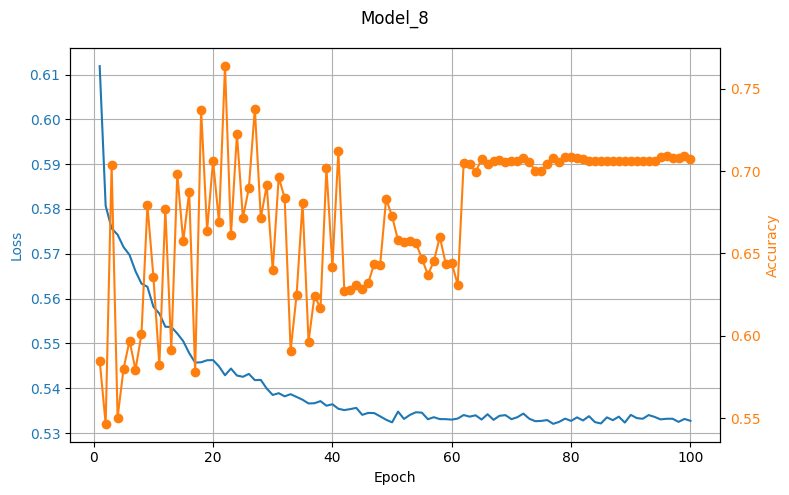

Model to test: Model_9
feature_dim: 12288
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x77d1ec4587f0>


Epoch 24/100 loss=0.5439 val_acc=0.7220 best=0.7900:  24%|▏| 24/100 [1:11:32<3:5

Epoch 00024: reducing learning rate of group 0 to 5.0000e-04.


Epoch 30/100 loss=0.5391 val_acc=0.7577 best=0.7900:  30%|▎| 30/100 [1:30:29<3:4

Epoch 00030: reducing learning rate of group 0 to 2.5000e-04.


Epoch 46/100 loss=0.5311 val_acc=0.7922 best=0.8043:  46%|▍| 46/100 [2:23:01<2:5

Epoch 00046: reducing learning rate of group 0 to 1.2500e-04.


Epoch 58/100 loss=0.5265 val_acc=0.7818 best=0.8059:  58%|▌| 58/100 [3:02:21<2:1

Epoch 00058: reducing learning rate of group 0 to 6.2500e-05.


Epoch 64/100 loss=0.5245 val_acc=0.7769 best=0.8059:  64%|▋| 64/100 [3:22:06<1:5

Epoch 00064: reducing learning rate of group 0 to 3.1250e-05.


Epoch 70/100 loss=0.5251 val_acc=0.7895 best=0.8059:  70%|▋| 70/100 [3:41:49<1:3

Epoch 00070: reducing learning rate of group 0 to 1.5625e-05.


Epoch 76/100 loss=0.5226 val_acc=0.7840 best=0.8059:  76%|▊| 76/100 [4:01:27<1:1

Epoch 00076: reducing learning rate of group 0 to 7.8125e-06.


Epoch 82/100 loss=0.5243 val_acc=0.7845 best=0.8059:  82%|▊| 82/100 [4:21:08<58:

Epoch 00082: reducing learning rate of group 0 to 3.9063e-06.


Epoch 88/100 loss=0.5236 val_acc=0.7829 best=0.8059:  88%|▉| 88/100 [4:40:55<39:

Epoch 00088: reducing learning rate of group 0 to 1.9531e-06.


Epoch 94/100 loss=0.5231 val_acc=0.7845 best=0.8059:  94%|▉| 94/100 [5:00:49<19:

Epoch 00094: reducing learning rate of group 0 to 9.7656e-07.


Epoch 100/100 loss=0.5229 val_acc=0.7796 best=0.8059: 100%|█| 100/100 [5:21:03<0

Epoch 00100: reducing learning rate of group 0 to 4.8828e-07.
Best val accuracy: 0.805921052631579


Final TEST accuracy: 0.812981298129813


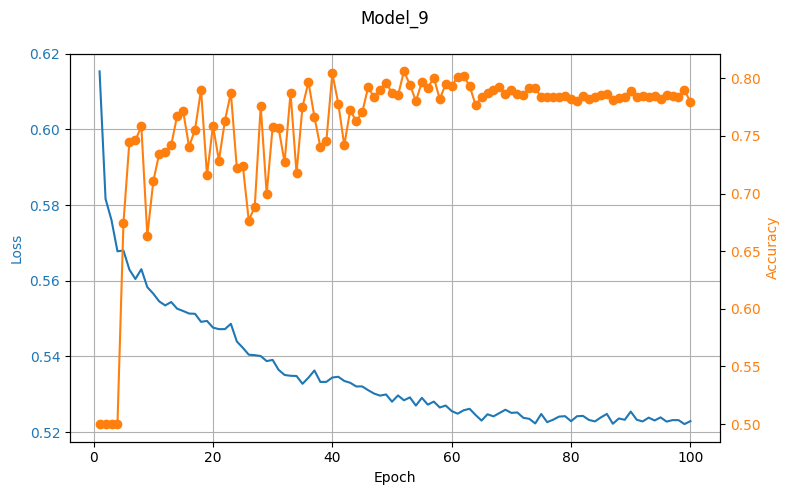

Model to test: Model_10
feature_dim: 512
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x77d201329120>


Epoch 27/100 loss=0.5529 val_acc=0.5965 best=0.7259:  27%|▎| 27/100 [48:17<2:08:

Epoch 00027: reducing learning rate of group 0 to 5.0000e-04.


Epoch 33/100 loss=0.5413 val_acc=0.6634 best=0.7259:  33%|▎| 33/100 [58:59<1:58:

Epoch 00033: reducing learning rate of group 0 to 2.5000e-04.


Epoch 39/100 loss=0.5388 val_acc=0.6568 best=0.7259:  39%|▍| 39/100 [1:09:40<1:4

Epoch 00039: reducing learning rate of group 0 to 1.2500e-04.


Epoch 48/100 loss=0.5325 val_acc=0.7281 best=0.7626:  48%|▍| 48/100 [1:25:43<1:3

Epoch 00048: reducing learning rate of group 0 to 6.2500e-05.


Epoch 54/100 loss=0.5322 val_acc=0.7259 best=0.7626:  54%|▌| 54/100 [1:36:19<1:2

Epoch 00054: reducing learning rate of group 0 to 3.1250e-05.


Epoch 60/100 loss=0.5321 val_acc=0.6776 best=0.7626:  60%|▌| 60/100 [1:47:07<1:1

Epoch 00060: reducing learning rate of group 0 to 1.5625e-05.


Epoch 66/100 loss=0.5301 val_acc=0.7286 best=0.7626:  66%|▋| 66/100 [1:57:50<1:0

Epoch 00066: reducing learning rate of group 0 to 7.8125e-06.


Epoch 72/100 loss=0.5293 val_acc=0.7039 best=0.7626:  72%|▋| 72/100 [2:08:26<49:

Epoch 00072: reducing learning rate of group 0 to 3.9063e-06.


Epoch 78/100 loss=0.5288 val_acc=0.6848 best=0.7626:  78%|▊| 78/100 [2:19:15<39:

Epoch 00078: reducing learning rate of group 0 to 1.9531e-06.


Epoch 84/100 loss=0.5302 val_acc=0.6837 best=0.7626:  84%|▊| 84/100 [2:29:53<28:

Epoch 00084: reducing learning rate of group 0 to 9.7656e-07.


Epoch 90/100 loss=0.5294 val_acc=0.7122 best=0.7626:  90%|▉| 90/100 [2:40:34<17:

Epoch 00090: reducing learning rate of group 0 to 4.8828e-07.


Epoch 96/100 loss=0.5291 val_acc=0.7018 best=0.7626:  96%|▉| 96/100 [2:51:23<07:

Epoch 00096: reducing learning rate of group 0 to 2.4414e-07.


Epoch 100/100 loss=0.5292 val_acc=0.7111 best=0.7626: 100%|█| 100/100 [2:58:24<0

Best val accuracy: 0.762609649122807


Final TEST accuracy: 0.7678767876787679


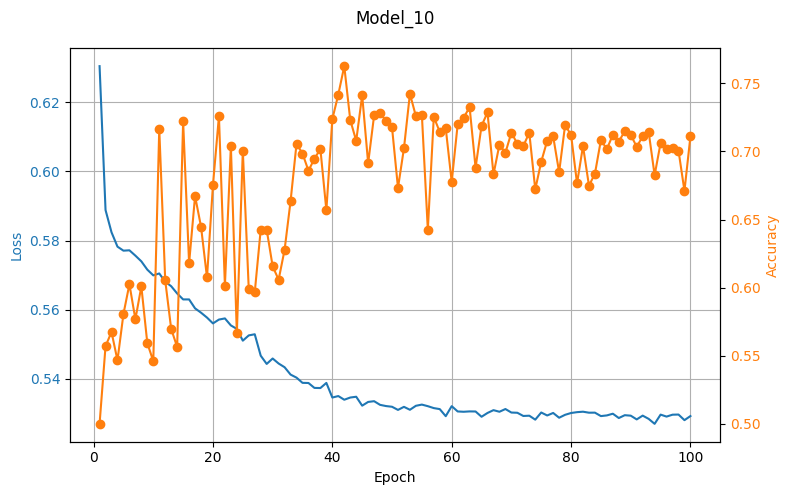

Model to test: Model_11
feature_dim: 2048
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x77d1ed081de0>


Epoch 7/100 loss=0.5733 val_acc=0.5000 best=0.5000:   7%| | 7/100 [10:24<2:17:34

Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.


Epoch 31/100 loss=0.5520 val_acc=0.6935 best=0.7670:  31%|▎| 31/100 [45:58<1:42:

Epoch 00031: reducing learning rate of group 0 to 2.5000e-04.


Epoch 37/100 loss=0.5480 val_acc=0.6579 best=0.7670:  37%|▎| 37/100 [54:50<1:33:

Epoch 00037: reducing learning rate of group 0 to 1.2500e-04.


Epoch 43/100 loss=0.5442 val_acc=0.7149 best=0.7670:  43%|▍| 43/100 [1:03:59<1:2

Epoch 00043: reducing learning rate of group 0 to 6.2500e-05.


Epoch 49/100 loss=0.5419 val_acc=0.7253 best=0.7670:  49%|▍| 49/100 [1:12:48<1:1

Epoch 00049: reducing learning rate of group 0 to 3.1250e-05.


Epoch 55/100 loss=0.5413 val_acc=0.6743 best=0.7670:  55%|▌| 55/100 [1:21:33<1:0

Epoch 00055: reducing learning rate of group 0 to 1.5625e-05.


Epoch 61/100 loss=0.5404 val_acc=0.6842 best=0.7670:  61%|▌| 61/100 [1:29:56<56:

Epoch 00061: reducing learning rate of group 0 to 7.8125e-06.


Epoch 67/100 loss=0.5396 val_acc=0.7308 best=0.7670:  67%|▋| 67/100 [1:38:03<45:

Epoch 00067: reducing learning rate of group 0 to 3.9063e-06.


Epoch 73/100 loss=0.5404 val_acc=0.7193 best=0.7670:  73%|▋| 73/100 [1:46:59<40:

Epoch 00073: reducing learning rate of group 0 to 1.9531e-06.


Epoch 79/100 loss=0.5401 val_acc=0.6804 best=0.7670:  79%|▊| 79/100 [1:55:21<28:

Epoch 00079: reducing learning rate of group 0 to 9.7656e-07.


Epoch 85/100 loss=0.5406 val_acc=0.6804 best=0.7670:  85%|▊| 85/100 [2:03:09<19:

Epoch 00085: reducing learning rate of group 0 to 4.8828e-07.


Epoch 91/100 loss=0.5412 val_acc=0.6798 best=0.7670:  91%|▉| 91/100 [2:11:42<12:

Epoch 00091: reducing learning rate of group 0 to 2.4414e-07.


Epoch 97/100 loss=0.5392 val_acc=0.6798 best=0.7670:  97%|▉| 97/100 [2:20:15<04:

Epoch 00097: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5396 val_acc=0.6815 best=0.7670: 100%|█| 100/100 [2:24:44<0

Best val accuracy: 0.7669956140350878


Final TEST accuracy: 0.7821782178217822


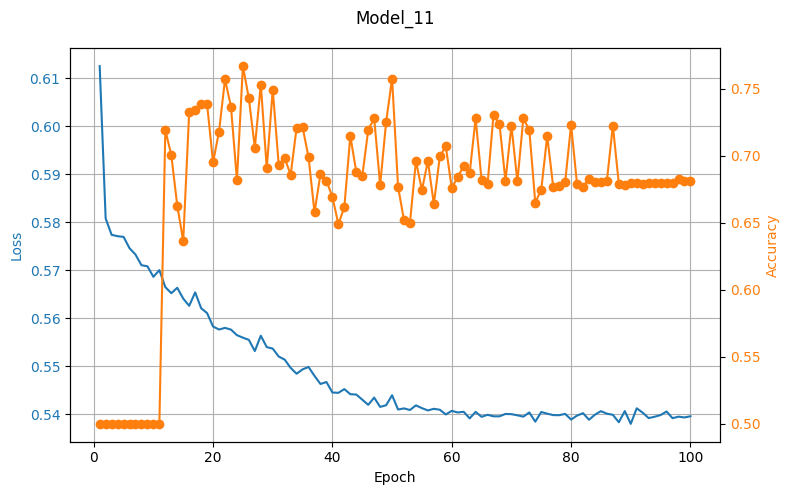

Model to test: Model_12
feature_dim: 1024
Criterion: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x77d1ed0e9330>


Epoch 21/100 loss=0.5605 val_acc=0.6036 best=0.7527:  21%|▏| 21/100 [38:29<2:24:

Epoch 00021: reducing learning rate of group 0 to 5.0000e-04.


Epoch 27/100 loss=0.5516 val_acc=0.6151 best=0.7527:  27%|▎| 27/100 [49:24<2:13:

Epoch 00027: reducing learning rate of group 0 to 2.5000e-04.


Epoch 33/100 loss=0.5463 val_acc=0.7034 best=0.7527:  33%|▎| 33/100 [1:00:22<2:0

Epoch 00033: reducing learning rate of group 0 to 1.2500e-04.


Epoch 39/100 loss=0.5428 val_acc=0.6168 best=0.7527:  39%|▍| 39/100 [1:11:15<1:5

Epoch 00039: reducing learning rate of group 0 to 6.2500e-05.


Epoch 50/100 loss=0.5408 val_acc=0.7341 best=0.7582:  50%|▌| 50/100 [1:31:17<1:3

Epoch 00050: reducing learning rate of group 0 to 3.1250e-05.


Epoch 56/100 loss=0.5400 val_acc=0.6683 best=0.7582:  56%|▌| 56/100 [1:42:05<1:1

Epoch 00056: reducing learning rate of group 0 to 1.5625e-05.


Epoch 62/100 loss=0.5392 val_acc=0.6826 best=0.7582:  62%|▌| 62/100 [1:53:03<1:0

Epoch 00062: reducing learning rate of group 0 to 7.8125e-06.


Epoch 68/100 loss=0.5402 val_acc=0.7001 best=0.7582:  68%|▋| 68/100 [2:03:55<57:

Epoch 00068: reducing learning rate of group 0 to 3.9063e-06.


Epoch 74/100 loss=0.5392 val_acc=0.7418 best=0.7582:  74%|▋| 74/100 [2:15:03<47:

Epoch 00074: reducing learning rate of group 0 to 1.9531e-06.


Epoch 80/100 loss=0.5391 val_acc=0.6897 best=0.7582:  80%|▊| 80/100 [2:25:50<36:

Epoch 00080: reducing learning rate of group 0 to 9.7656e-07.


Epoch 86/100 loss=0.5387 val_acc=0.7412 best=0.7582:  86%|▊| 86/100 [2:36:53<25:

Epoch 00086: reducing learning rate of group 0 to 4.8828e-07.


Epoch 92/100 loss=0.5400 val_acc=0.6891 best=0.7582:  92%|▉| 92/100 [2:47:49<14:

Epoch 00092: reducing learning rate of group 0 to 2.4414e-07.


Epoch 98/100 loss=0.5389 val_acc=0.6870 best=0.7582:  98%|▉| 98/100 [2:58:47<03:

Epoch 00098: reducing learning rate of group 0 to 1.2207e-07.


Epoch 100/100 loss=0.5386 val_acc=0.6809 best=0.7582: 100%|█| 100/100 [3:02:26<0

Best val accuracy: 0.7582236842105263


Final TEST accuracy: 0.7645764576457645


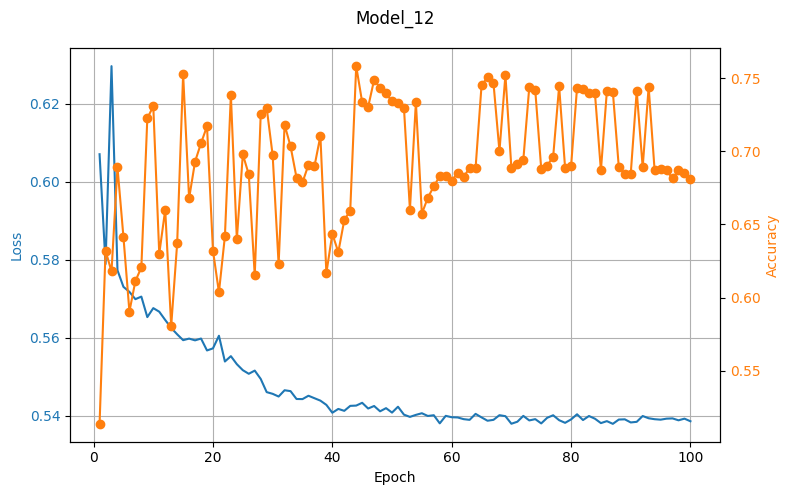

In [104]:
run_experiment(Model8_Bottleneck1x1, "Model_8", 100)
run_experiment(Model9_VGGLite, "Model_9", 100)
run_experiment(Model10_MorePooling, "Model_10", 100)
run_experiment(Model11_CappedChannels, "Model_11", 100)
run_experiment(Model12_ShrinkBeforeFC, "Model_12", 100)